## Image Focus and Astigmatism Classifier
**Author:** [Aaron Woods](https://aaronwoods.info)  
**Date Created:** September 21, 2023  
**Description:** This script provides an end-to-end machine learning pipeline to classify images as either "In Focus" or "Out of Focus", and additionally identifies astigmatism-related issues.  
**Repository:** [Image Classification on VSCode](https://insiders.vscode.dev/tunnel/midnightsim/c:/Users/User/Desktop/Image-Classification)

### Overview
The script features a comprehensive pipeline that ingests data from Excel spreadsheets and feeds it into various machine learning models. The design is modular, allowing for easy adaptability to address different image classification problems, including focus quality and astigmatism detection.


## Setup

In [1]:
# ------------------------------
# TensorFlow Installation with GPU Support
# ------------------------------
# Note: TensorFlow versions above 2.10 are not supported on GPUs on native Windows installations.
# For more details, visit: https://www.tensorflow.org/install/pip#windows-wsl2_1

# Uncomment the following line to install TensorFlow if needed.
!pip install "tensorflow<2.11" --user

# ------------------------------
# System and TensorFlow Info Check
# ------------------------------
# Import necessary libraries and initialize an empty dictionary to store system information.
import platform
system_info = {"Platform": platform.platform(), "Python Version": platform.python_version()}

# Try importing TensorFlow and collecting relevant system information.
try:
    import tensorflow as tf
    system_info.update({
        "TensorFlow Version": tf.__version__,
        "Num GPUs Available": len(tf.config.list_physical_devices('GPU'))
    })
    system_info['Instructions'] = (
        "You're all set to run your model on a GPU." 
        if system_info['Num GPUs Available'] 
        else (
            "No GPUs found. To use a GPU, follow these steps:\n"
            "  1. Install NVIDIA drivers for your GPU.\n"
            "  2. Install a compatible CUDA toolkit.\n"
            "  3. Install the cuDNN library.\n"
            "  4. Make sure to install the GPU version of TensorFlow."
        )
    )
except ModuleNotFoundError:
    system_info['Instructions'] = (
        "TensorFlow is not installed. "
        "Install it using pip by running: !pip install tensorflow"
    )

# Format and display the gathered system information.
formatted_info = "\n".join(f"{key}: {value}" for key, value in system_info.items())
print(formatted_info)



Platform: Windows-10-10.0.17763-SP0
Python Version: 3.9.18
TensorFlow Version: 2.10.1
Num GPUs Available: 1
Instructions: You're all set to run your model on a GPU.


In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
    
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# ------------------------------
# Package Installation (Optional)
# ------------------------------
# Uncomment the following lines to install required packages if running on a new machine.
# To suppress the output, we use '> /dev/null 2>&1'.
!pip install opencv-python numpy pandas matplotlib protobuf seaborn scikit-learn

# ------------------------------
# Import Libraries
# ------------------------------

# Standard Libraries
import os, sys, random, math, glob, logging
from datetime import datetime
from collections import defaultdict

# Third-Party Libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
from IPython.display import clear_output
from collections import Counter
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.callbacks import TensorBoard, Callback
from tensorflow.keras.applications import InceptionV3, ResNet50
from keras.models import load_model
from tensorflow.data import Dataset

import pickle

# Type Annotations
from typing import List, Dict, Tuple, Union, Any, Optional


In [4]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


## Configuration

In [5]:
# Configuration dictionary
config = {
    'Experiment': {
        'NAME': "PC_Unbalanced_GPU",  # Experiment name
        'RANDOM_SEED': 42,  # Seed for reproducibility
        'PROBLEM_TYPE': 'Multi-Output',  # Problem type: Binary, Multi-Class, Multi-Output, Multi-Label
    },
    'Model': {
        'IMG_SIZE': 224,  # Image input size
        'BATCH_SIZE': 8,  # Batch size for training
        'TRAIN_SIZE': 0.8,  # Fraction of data to use for training
        'VAL_SIZE': 0.5,  # Fraction of data to use for validation
        'EPOCHS': 100,  # Number of training epochs
        'LEARNING_RATE': 0.001,  # Learning rate 1e-3
        'EARLY_STOPPING_PATIENCE': 15,  # Early stopping patience
        'REDUCE_LR_PATIENCE':3,  # Reduce learning rate on plateau patience
        'MIN_LR': 1e-6,  # Minimum learning rate
    },
    'Labels': {
        'MAPPINGS': {  # Class label mappings
            'Focus_Label': {'SharpFocus': 0, 'SlightlyBlurred': 1, 'HighlyBlurred': 2},
            'StigX_Label': {'OptimalStig_X': 0, 'ModerateStig_X': 1, 'SevereStig_X': 2},
            'StigY_Label': {'OptimalStig_Y': 0, 'ModerateStig_Y': 1, 'SevereStig_Y': 2},
        }
    },
    'Augmentation': {  # Data augmentation parameters
        'rotation_factor': 0.002,
        'height_factor': (-0.18, 0.18),
        'width_factor': (-0.18, 0.18),
        'contrast_factor': 0.5,
    }
}


In [6]:
# Configure for dataset creation

csv_config = {
    'CSV': {
        'COLUMNS_TO_READ': ['ImageFile', 'Focus_Offset (V)', 'Stig_Offset_X (V)', 'Stig_Offset_Y (V)']
    },
    'Thresholds': {
        'FOCUS_LOW': 30,  # Lower focus threshold
        'FOCUS_HIGH': 60,  # Upper focus threshold
        'STIGX_LOW': 1,  # Lower astigmatism threshold
        'STIGX_HIGH': 2,  # Upper astigmatism threshold
        'STIGY_LOW': 1,  # Lower astigmatism threshold
        'STIGY_HIGH': 2,  # Upper astigmatism threshold
    },
    'Paths': {  # Data and model paths
        # 'DATA_FILE': "combined_output_cleaned.csv",
        'DATA_FILE': "combined_output.csv",
        'OLD_BASE_PATH': "D:\\DOE\\",
        'NEW_BASE_PATH': "Y:\\User\\Aaron-HX38\\DOE\\", # On Simulation Computer
        # 'NEW_BASE_PATH': "C:\\Users\\aaron.woods\\OneDrive - Thermo Fisher Scientific\\Desktop\\Dec 24\\",
    },
    'SAMPLE_FRAC': 1,  # Fraction of the data to use for quicker prototyping. 1.0 means use all data.
}
config.update(csv_config)


In [7]:
# Set random seed for reproducibility
np.random.seed(config['Experiment']['RANDOM_SEED'])
tf.random.set_seed(config['Experiment']['RANDOM_SEED'])

## Load and Preprocess the data

### Functions for Preparation of CSV

In [8]:
# Read the data

def read_csv(config: Dict):
    # Functionality to read the data
    data_file_path = os.path.join(config['Paths']['NEW_BASE_PATH'], config['Paths']['DATA_FILE'])
    if not os.path.exists(data_file_path):
        raise FileNotFoundError(f"Error: File does not exist - {data_file_path}")
    try:
        data = pd.read_csv(data_file_path, usecols=config['CSV']['COLUMNS_TO_READ'])
        print("---> Data read successfully.")
        sample_frac = config.get('SAMPLE_FRAC', 1.0)
        if 0 < sample_frac < 1.0:
            data = data.sample(frac=sample_frac).reset_index(drop=True)
            print(f"---> Data sampled: Using {sample_frac * 100}% of the available data.")
    except Exception as e:
        raise ValueError(f"Error: Could not read data - {e}") from e
    return data

def update_image_paths(df):
    old_base_path = config['Paths']['OLD_BASE_PATH']
    new_base_path = config['Paths']['NEW_BASE_PATH']
    df['ImageFile'] = df['ImageFile'].str.replace(old_base_path, new_base_path, regex=False)
    print("---> Image paths updated.")
    return df


def clean_csv(df: pd.DataFrame, save_cleaned: bool = False) -> pd.DataFrame:
    def is_valid_string(image_path) -> bool:
        return isinstance(image_path, str)
    
    def does_file_exist(image_path) -> bool:
        return os.path.exists(image_path)
    
    def can_image_be_read(image_path) -> bool:
        img = cv2.imread(image_path)
        return img is not None
    
    removal_reasons = defaultdict(list)
    total_rows = len(df)
    csv_file_path = os.path.join(config['Paths']['NEW_BASE_PATH'], config['Paths']['DATA_FILE'])
    print("Cleaning CSV file...")
    for index, row in enumerate(df.itertuples()):
        progress = (index + 1) / total_rows * 100
        print(f"\rProgress: {progress:.2f}%", end="")
        
        image_path = row.ImageFile
        reason = None
        
        if not is_valid_string(image_path):
            reason = "Invalid ImageFile value - not a string"
        elif not does_file_exist(image_path):
            reason = "File does not exist"
        elif not can_image_be_read(image_path):
            reason = "Image can't be read"
        
        if reason:
            removal_reasons[reason].append(index)
    
    invalid_rows = [index for indices in removal_reasons.values() for index in indices]
    df.drop(index=invalid_rows, inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    print("\n\nSummary of row removals:")
    for reason, indices in removal_reasons.items():
        print(f"{len(indices)} rows removed due to: {reason}")
        print(f"Row indices: {indices}")
    
    if save_cleaned and csv_file_path:
        cleaned_csv_file_path = f"{os.path.splitext(csv_file_path)[0]}_cleaned.csv"
        df.to_csv(cleaned_csv_file_path, index=False)
        print(f"Cleaned CSV saved to: {cleaned_csv_file_path}")
    
    return df


### Generating labels

In [9]:
# Generating labels
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
import numpy as np
import pandas as pd
from typing import Dict

def generate_thresholds(label_key):
    low_key = f"{label_key.split('_')[0].upper()}_LOW"
    high_key = f"{label_key.split('_')[0].upper()}_HIGH"
    return config.get('Thresholds', {}).get(low_key, 0), config.get('Thresholds', {}).get(high_key, 0)

def generate_single_label(df_copy, label_key, offset_column, choices_dict):
    low_threshold, high_threshold = generate_thresholds(label_key)
    conditions = [
        (df_copy[offset_column].abs() <= low_threshold),
        (df_copy[offset_column].abs() > low_threshold) & (df_copy[offset_column].abs() <= high_threshold),
        (df_copy[offset_column].abs() > high_threshold)
    ]
    choices = list(choices_dict.keys())
    df_copy[label_key] = np.select(conditions, choices, default='Unknown')
    le = LabelEncoder()
    df_copy[label_key] = le.fit_transform(df_copy[label_key])
    return le

def generate_labels(df: pd.DataFrame):
    print("---> Generating labels for Focus, StigX, and StigY...")
    labels_config = config.get('Labels', {}).get('MAPPINGS', {})
    offset_column_mapping = {'Focus_Label': 'Focus_Offset (V)', 'StigX_Label': 'Stig_Offset_X (V)', 'StigY_Label': 'Stig_Offset_Y (V)'}

    df_copy = df.copy()
    label_encoders = {}

    for label_key, choices_dict in labels_config.items():
        offset_column = offset_column_mapping.get(label_key)
        if not offset_column:
            print(f"Warning: No offset column mapping found for '{label_key}'. Skipping label generation.")
            continue
        if offset_column not in df.columns:
            print(f"Warning: Column '{offset_column}' not found in DataFrame. Skipping label generation for '{label_key}'.")
            continue
        label_encoders[label_key] = generate_single_label(df_copy, label_key, offset_column, choices_dict)
        print(f"---> Labels generated for {label_key}")

    if config.get('Experiment', {}).get('PROBLEM_TYPE') == 'Multi-Output':
        df_copy['Multi_Output_Labels'] = df_copy.apply(lambda row: [row[key] for key in labels_config.keys()], axis=1)
        print("---> Multi-Output Labels generated.")
        
    return df_copy, label_encoders


### Shuffling and Splitting the Data

In [10]:
# Shuffling and Splitting the data

def shuffle_and_reset_index(data):
    print("---> Shuffling and resetting index...")
    shuffled_df = data.sample(frac=1, random_state=config['Experiment']['RANDOM_SEED']).reset_index(drop=True)
    print("---> Data shuffled and index reset.")
    return shuffled_df

def prepare_datasets(df: pd.DataFrame):
    """Prepare training, validation, and test datasets."""
    # Check if DataFrame is empty
    if df is None or df.empty:
        print("Warning: DataFrame is empty. Cannot proceed with data preparation.")
        return {'train': None, 'valid': None, 'test': None}
    # Split Data
    try:
        train_df, temp_df = train_test_split(df, test_size=1 - config['Model']['TRAIN_SIZE'], random_state=config['Experiment']['RANDOM_SEED'])
        val_df, test_df = train_test_split(temp_df, test_size=1 - config['Model']['VAL_SIZE'], random_state=config['Experiment']['RANDOM_SEED'])
    except ValueError:
        print("Not enough data to split into training, validation, and test sets.")
        return {'train': None, 'valid': None, 'test': None}
    print("---> Data split into training, validation, and test sets.")
    return {'train': train_df, 'valid': val_df, 'test': test_df}

### Computting Class Weights

In [11]:
# Compute class weights

from collections import Counter
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import pandas as pd
from typing import Dict


def compute_multi_output_class_weights(split: str, df: pd.DataFrame, label: str, label_encoders: Dict[str, LabelEncoder], all_records: List[Dict]) -> None:
    unique_labels = df[label].unique()
    class_weights = compute_class_weight('balanced', classes=np.unique(unique_labels), y=df[label])
    class_weights_dict = dict(zip(unique_labels, class_weights))
    for cls, weight in class_weights_dict.items():
        cnt = Counter(df[label])[cls]
        original_class = label_encoders[label].inverse_transform([cls])[0]
        all_records.append({'split': split, 'label': label, 'class': original_class, 'Count': cnt, 'Weight': weight})

def compute_multi_label_class_weights(split: str, df: pd.DataFrame, label: str, label_encoders: Dict[str, LabelEncoder], all_records: List[Dict]) -> None:
    label_data = df[label].values
    unique_labels = np.unique(label_data)
    class_weights = compute_class_weight('balanced', classes=np.unique(unique_labels), y=label_data)
    class_weights_dict = dict(zip(unique_labels, class_weights))
    for cls, weight in class_weights_dict.items():
        cnt = Counter(label_data)[cls]
        original_class = label_encoders[label].inverse_transform([cls])[0]
        all_records.append({'split': split, 'label': label, 'class': original_class, 'Count': cnt, 'Weight': weight})

def compute_and_store_class_weights(datasets: Dict[str, pd.DataFrame], label_encoders: Dict[str, LabelEncoder]) -> pd.DataFrame:
    problem_type = config.get('Experiment', {}).get('PROBLEM_TYPE', 'Binary')
    all_records = []
    
    for split, df in datasets.items():
        if df is None:
            continue
        for label in config['Labels']['MAPPINGS']:
            if problem_type == 'Multi-label':
                compute_multi_label_class_weights(split, df, label, label_encoders, all_records)
            else:
                compute_multi_output_class_weights(split, df, label, label_encoders, all_records)
                
    df_class_weights = pd.DataFrame.from_records(all_records)
    df_class_weights.set_index(['split', 'label', 'class'], inplace=True)
    return df_class_weights

### Creating Tensorflow Datasets

In [12]:
# Create TensorFlow datasets

def create_tf_datasets_from_dfs(dfs: Dict[str, pd.DataFrame], include_offset=False) -> Dict[str, Dict[str, Any]]:
    """
    Create TensorFlow datasets from DataFrames for training, validation, and testing.
    Parameters:
    - dfs: Dictionary containing DataFrames for 'train', 'val', and 'test'.
    Returns:
    - Dictionary containing TensorFlow datasets for each split.
    """
    problem_type = config.get('Experiment', {}).get('PROBLEM_TYPE')
    batch_size = config.get('Model', {}).get('BATCH_SIZE', 32)
    AUTOTUNE = tf.data.AUTOTUNE
    # Create preprocessing and augmentation layers
    preprocessing_layers = create_preprocessing_layers()
    augmentation_layers = create_augmentation_layers()
    # Initialize output dictionary
    tf_datasets = {'train': {}, 'valid': {}, 'test': {}}
    
    def load_and_preprocess_image(file_path, label, offset=None, augment=False):
        file_path_str = file_path.numpy().decode('utf-8')
        image = read_and_convert_image(file_path_str)
        image = preprocessing_layers(image)
        label = tf.cast(label, tf.int32)  # Explicitly casting to tf.int32
        offset = tf.cast(offset, tf.float32) if offset is not None else None
        if augment:
            image = augmentation_layers(image)
            image = tf.clip_by_value(image, 0.0, 1.0)
        return (image, label, offset) if include_offset else (image, label)
    
    
    offset_column_mapping = {
        'Focus_Label': 'Focus_Offset (V)',
        'StigX_Label': 'Stig_Offset_X (V)',
        'StigY_Label': 'Stig_Offset_Y (V)'}
    for split, df in dfs.items():
        augment_data = (split == 'train')
        if problem_type in ['Multi-Class', 'Binary']:
            for label in ['Focus_Label', 'StigX_Label', 'StigY_Label']:
                offset_column = offset_column_mapping.get(label)
                offsets_tensor = df[offset_column].values if include_offset else None
                
                ds = tf.data.Dataset.from_tensor_slices((df['ImageFile'].values, df[label].values, offsets_tensor))

                # Handling offset inside the lambda
                ds = ds.map(lambda file_path, label, offset: tf.py_function(
                    func=load_and_preprocess_image,
                    inp=[file_path, label, offset if offset is not None else tf.constant([], dtype=tf.float32), augment_data],
                    Tout=[tf.float32, label.dtype, tf.float32] if include_offset else [tf.float32, label.dtype]
                ))
                
                ds = ds.batch(batch_size)
                # ds = ds.cache().prefetch(buffer_size=AUTOTUNE) Memory error
                ds = ds.prefetch(buffer_size=AUTOTUNE)
                tf_datasets[split][label] = ds

        elif problem_type == 'Multi-Output':
            labels_tensor = df[['Focus_Label', 'StigX_Label', 'StigY_Label']].values
            offsets_tensor = df[['Focus_Offset (V)', 'Stig_Offset_X (V)', 'Stig_Offset_Y (V)']].values if include_offset else None
            ds = tf.data.Dataset.from_tensor_slices((df['ImageFile'].values, labels_tensor, offsets_tensor))
            
            # Handling offset inside the lambda
            ds = ds.map(lambda file_path, label, offset: tf.py_function(
                func=load_and_preprocess_image,
                inp=[file_path, label, offset if offset is not None else tf.constant([], dtype=tf.float32), augment_data],
                Tout=[tf.float32, label.dtype, tf.float32] if include_offset else [tf.float32, label.dtype]
            ))
            
            ds = ds.batch(batch_size)
            # ds = ds.cache().prefetch(buffer_size=AUTOTUNE)
            ds = ds.prefetch(buffer_size=AUTOTUNE)
            tf_datasets[split]['Multi_Output'] = ds

        else:
            print("Unknown problem type specified in config. Please check.")

    return tf_datasets



# Image Augmentation and Preprocessing

def create_preprocessing_layers() -> keras.Sequential:
    """Create preprocessing layers for resizing and rescaling images."""
    img_size = config['Model']['IMG_SIZE']
    return keras.Sequential([
        layers.Resizing(img_size, img_size),
        layers.Rescaling(1./255)
    ])

def create_augmentation_layers() -> keras.Sequential:
    """Create data augmentation layers."""
    aug_config = config['Augmentation']
    try:
        return keras.Sequential([
            layers.RandomFlip("horizontal"),
            layers.RandomFlip("vertical"),
            layers.RandomRotation(aug_config['rotation_factor']),
            layers.RandomTranslation(
                height_factor=aug_config['height_factor'],
                width_factor=aug_config['width_factor'],
                fill_mode="reflect"
            ),
            layers.RandomContrast(aug_config['contrast_factor']),
        ])
        
    except Exception as e:
        print(f"An error occurred while creating augmentation layers: {e}")
        return None

def read_and_convert_image(file_path: str) -> tf.Tensor:
    """Read an image from a file and convert it to a 3-channel tensor."""
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print("Failed to read the image.")
        return None
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    image = tf.expand_dims(image, axis=-1)
    return tf.image.grayscale_to_rgb(image)


### Resample Datasets to deal with Imbalances

In [13]:
from sklearn.utils import resample
import pandas as pd

def validate_inputs(datasets, resample_label, resample_strategy):
    """
    Validates the inputs provided to the resampling function.
    """
    
    # Ensure that datasets is a dictionary
    if not isinstance(datasets, dict):
        raise ValueError("Input datasets should be a dictionary.")
    
    # Check if resample_strategy is one of the allowed values
    if resample_strategy not in ["upsample", "downsample", "combined"]:
        raise ValueError("Invalid resample_strategy. Choose from 'upsample', 'downsample', or 'combined'.")
    
    # Ensure the resample_label exists in all the datasets
    for key, df in datasets.items():
        if resample_label not in df.columns:
            raise ValueError(f"'{resample_label}' is not a valid column in the {key} dataset.")

def iterative_resampling(df, label_counts, resample_strategy, resample_label):
    """
    Iteratively resample the dataset based on the given resampling strategy.
    """
    
    resampled_data_list = []
    
    # Get the minimum and maximum label counts
    min_count = label_counts.min()
    max_count = label_counts.max()
    
    # If the strategy is "combined", set the target size to the median class size
    if resample_strategy == "combined":
        target_count = int(label_counts.median())
    else:
        target_count = None

    # Iterate over each unique label and resample accordingly
    for unique_label in label_counts.keys():
        subset = df[df[resample_label].apply(tuple) == unique_label]
        count = len(subset)

        # Determine the target count based on resampling strategy
        if resample_strategy == "downsample":
            target_count = min_count
        elif resample_strategy == "upsample":
            target_count = max_count

        # Resample the subset if its count doesn't match the target count
        if count != target_count:
            resampled_data_list.append(resample(subset, replace=(count < target_count), n_samples=target_count))
        else:
            resampled_data_list.append(subset)
            
    # Concatenate the resampled data to form a single dataframe
    return pd.concat(resampled_data_list)


def resample_datasets(datasets, resample_label='Multi_Output_Labels', resample_strategy="downsample"):
    """
    Iteratively resample a multi-class, multi-label (multi-output) dataset that is unbalanced.
    """
    
    # Validate the inputs before processing
    validate_inputs(datasets, resample_label, resample_strategy)
    
    # Identify columns with 'int32' datatype in the input datasets
    int32_columns = [col for col, dtype in datasets.get('train', pd.DataFrame()).dtypes.items() if dtype == 'int32']
    
    resampled_datasets = {}
    
    # Iterate over each dataset (train, test, etc.) and apply resampling only to the training set
    for key, df in datasets.items():
        print(f"Processing {key} dataset...")
        if key == 'train':
            label_counts = df[resample_label].apply(tuple).value_counts()
            resampled_data = iterative_resampling(df, label_counts, resample_strategy, resample_label)
            
            # Shuffle the data and reset its index
            resampled_data = resampled_data.sample(frac=1).reset_index(drop=True)

            # Convert specified columns to 'int32' datatype
            for col in int32_columns:
                resampled_data[col] = resampled_data[col].astype('int32')

            resampled_datasets[key] = resampled_data
        else:
            resampled_datasets[key] = df

    return resampled_datasets


## Main Function for Data Preparation

In [14]:


print("===== Preprocessing CSV Data =====")
data = read_csv(config)
data = update_image_paths(data)
data = clean_csv(data, save_cleaned=False)
data, label_encoders = generate_labels(data)
data = shuffle_and_reset_index(data)
print("===== Preparing TensorFlow Datasets =====")
datasets = prepare_datasets(data)
df_class_weights = compute_and_store_class_weights(datasets, label_encoders)
resampled_datasets = resample_datasets(datasets, resample_label='Multi_Output_Labels', resample_strategy="combined")
rdf_class_weights = compute_and_store_class_weights(resampled_datasets, label_encoders)
datasets = create_tf_datasets_from_dfs(datasets, include_offset=True)
resampled_datasets = create_tf_datasets_from_dfs(resampled_datasets, include_offset=True)
print("===== Preprocessing Complete =====")


===== Preprocessing CSV Data =====
---> Data read successfully.
---> Image paths updated.
Cleaning CSV file...
Progress: 0.02%

Progress: 100.00%

Summary of row removals:
1 rows removed due to: File does not exist
Row indices: [188]
---> Generating labels for Focus, StigX, and StigY...
---> Labels generated for Focus_Label
---> Labels generated for StigX_Label
---> Labels generated for StigY_Label
---> Multi-Output Labels generated.
---> Shuffling and resetting index...
---> Data shuffled and index reset.
===== Preparing TensorFlow Datasets =====
---> Data split into training, validation, and test sets.
Processing train dataset...
Processing valid dataset...
Processing test dataset...
===== Preprocessing Complete =====


## Visualize the data

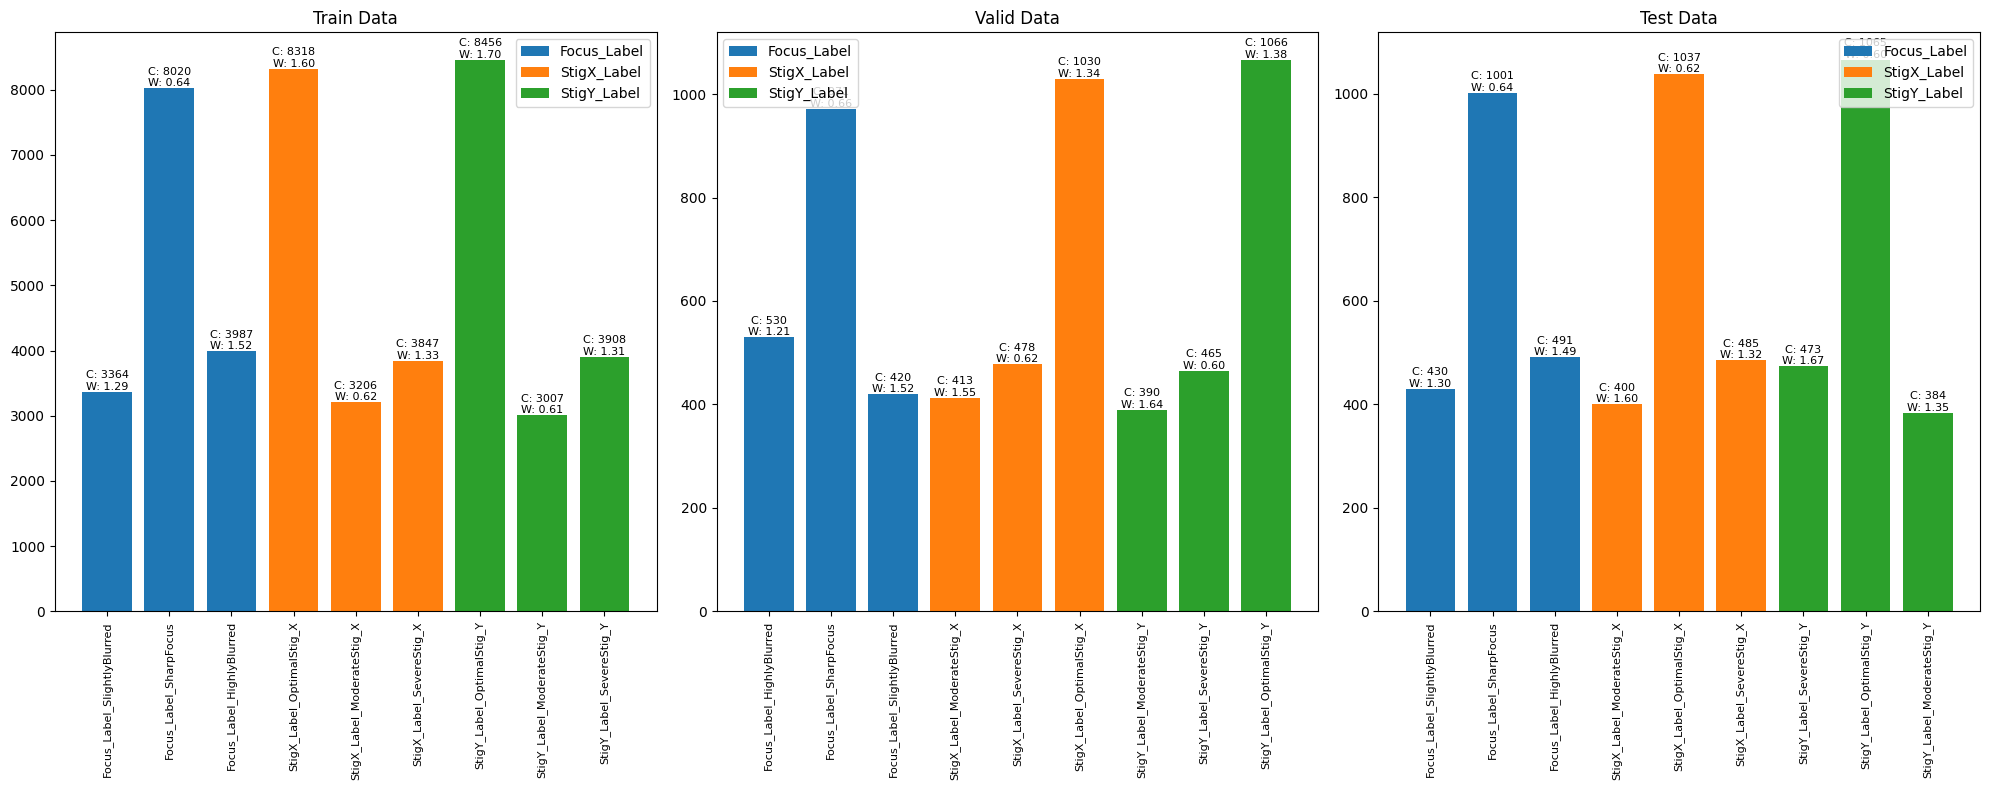

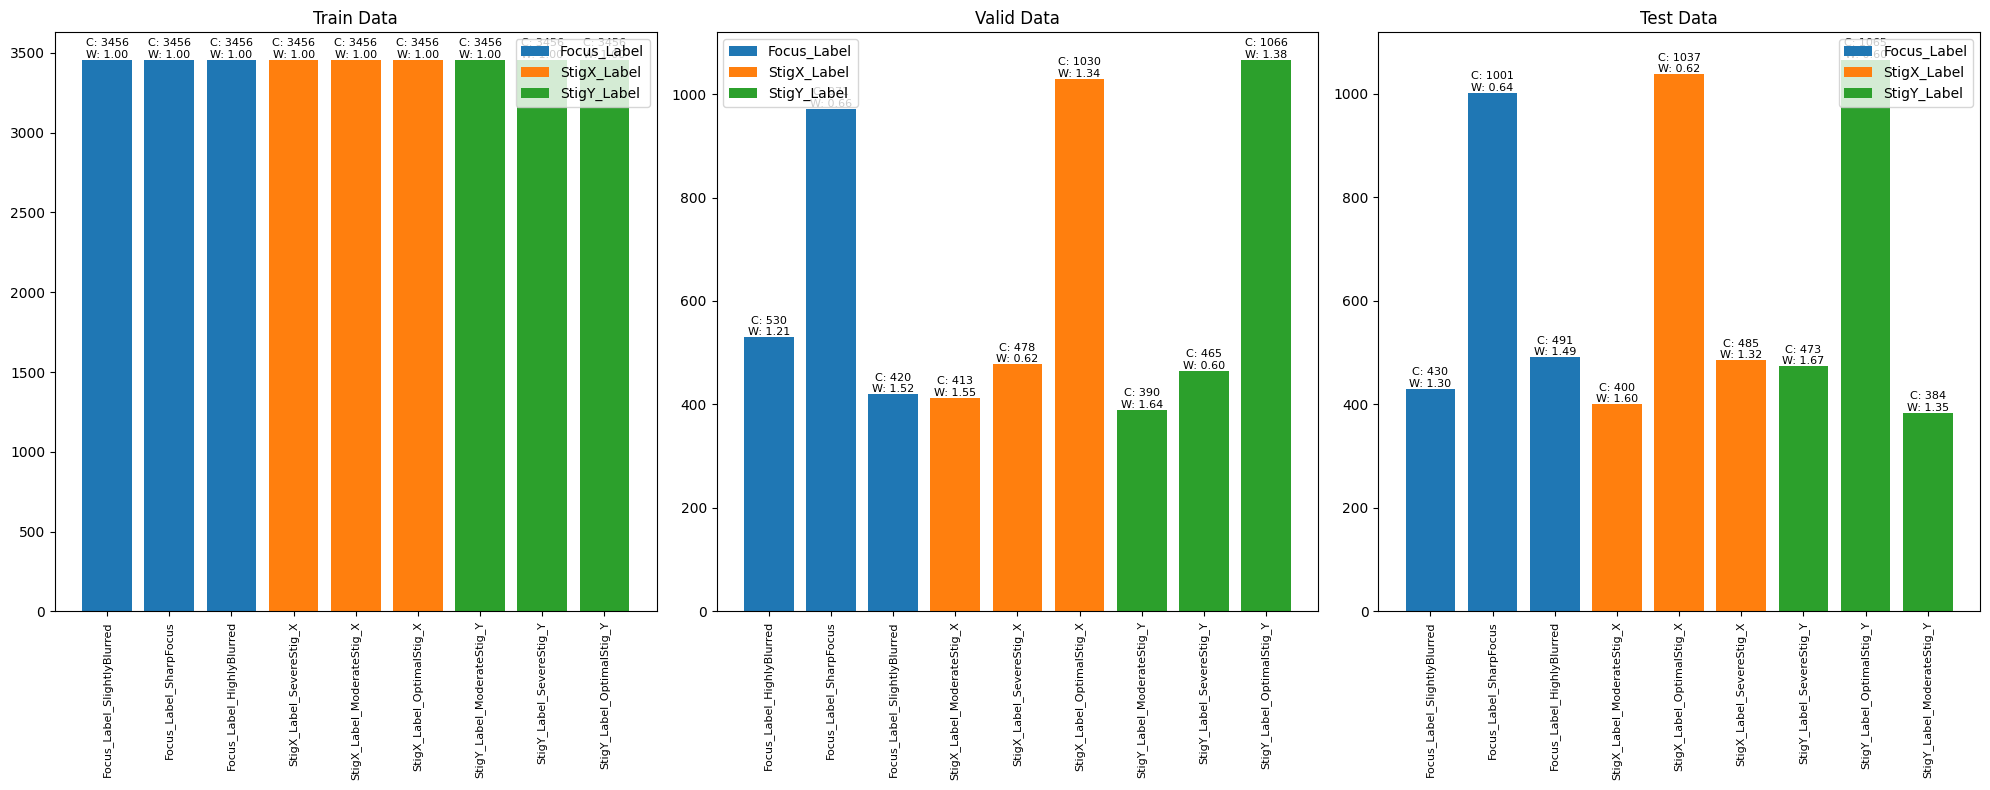

In [15]:
# Show Class Distributions

def add_annotations(ax, bars, sub_df):
    for bar, (_, row) in zip(bars, sub_df.iterrows()):
        x = bar.get_x() + bar.get_width() / 2.0
        y = bar.get_height()
        ax.annotate(f"C: {int(row['Count'])}\nW: {row['Weight']:.2f}", 
                    (x, y), 
                    ha='center', 
                    va='bottom', 
                    fontsize=8)

def plot_single_split(ax, df, split):
    filtered_df = df.loc[split]
    x_ticks = []
    x_tick_locs = []
    
    current_x = 0  # Keep track of the current x-location for ticks
    
    labels = filtered_df.index.get_level_values('label').unique()
    for label in labels:
        sub_df = filtered_df.loc[label]
        bars = ax.bar(sub_df.index, sub_df['Count'], label=f"{label}")
        add_annotations(ax, bars, sub_df)
        
        x_ticks.extend([f"{label}_{cls}" for cls in sub_df.index])
        x_tick_locs.extend([current_x + i for i in range(len(sub_df.index))])
        
        current_x += len(sub_df.index)  # Update the x-location for the next set of bars
    
    ax.legend()
    ax.set_xticks(x_tick_locs)  # Set tick locations
    ax.set_xticklabels(x_ticks, rotation=90, fontsize=8)  # Now set tick labels
    ax.set_title(f"{split.capitalize()} Data")


def plot_dataset_info(df):
    splits = ['train', 'valid', 'test']
    
    fig, axs = plt.subplots(1, len(splits), figsize=(20, 8))
    
    for i, split in enumerate(splits):
        plot_single_split(axs[i], df, split)
        
    plt.tight_layout()
    plt.show()


# Example usage
plot_dataset_info(df_class_weights)
plot_dataset_info(rdf_class_weights)

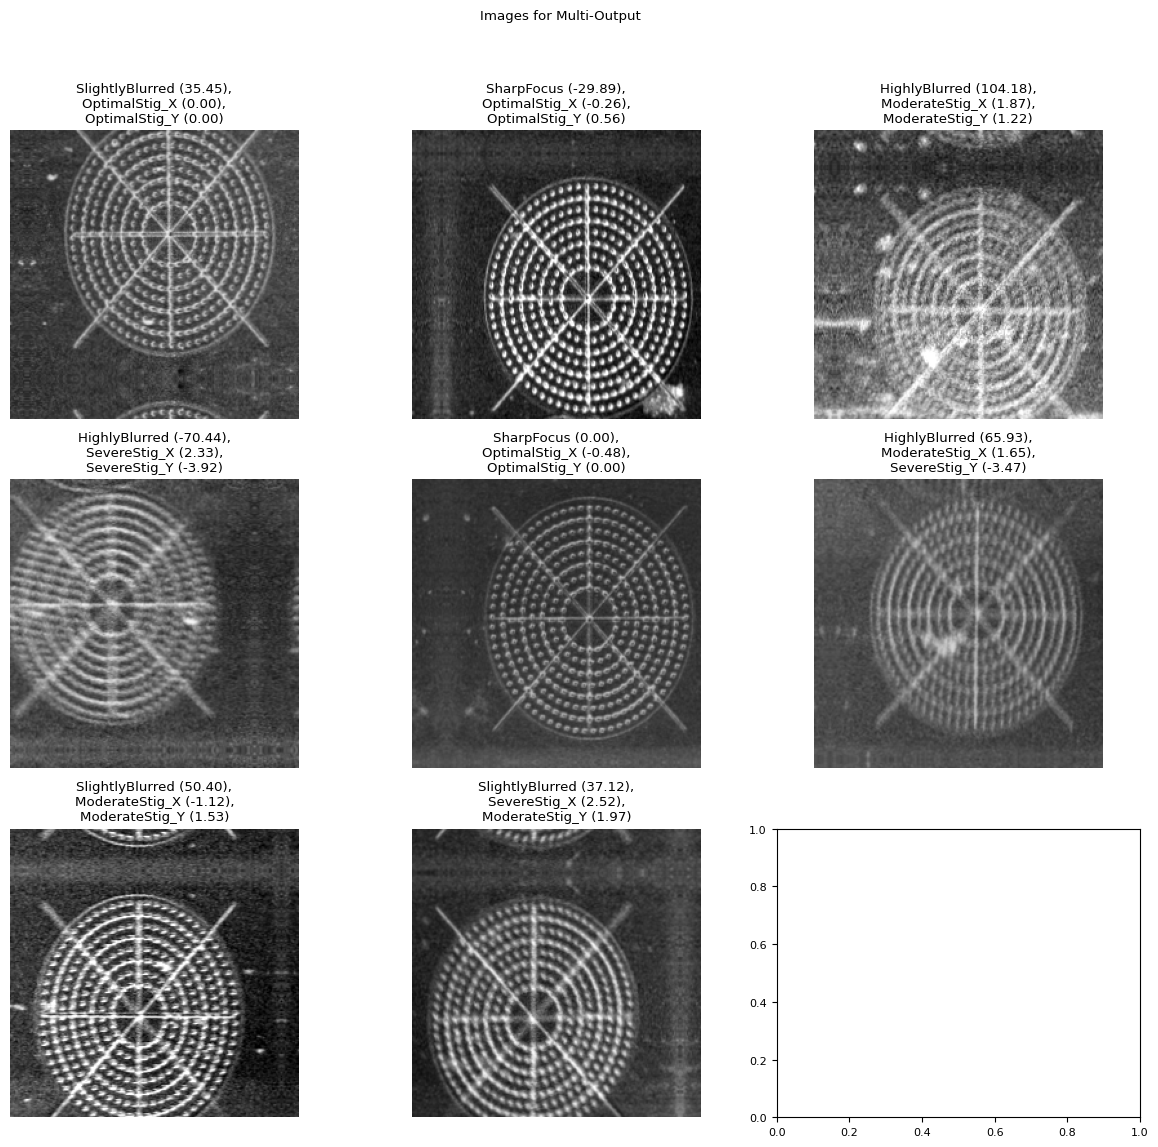

In [16]:
import textwrap
import matplotlib.pyplot as plt

def plot_images_from_dataset(label_encoders, config, datasets):
    """
    Plots images, labels, and offsets (if available) from the provided datasets.
    
    Args:
        label_encoders (dict): Dictionary of label encoders for each label key.
        config (dict): Configuration dictionary containing problem type and other parameters.
        datasets (dict): Dictionary of datasets, containing training data for each label key.
        
    Returns:
        None
    """
    label_keys = ['Focus_Label', 'StigX_Label', 'StigY_Label']
    problem_type = config['Experiment']['PROBLEM_TYPE']

    plt.rcParams.update({'font.size': 8})  # Reduce font size
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))  # Enlarge figure size

    if problem_type in ['Multi-Class', 'Binary']:
        for label_key in label_keys:
            label_encoder = label_encoders.get(label_key, None)
            fig.suptitle(f"Images for {label_key}")

            # Take one batch from the training dataset
            for data in datasets['train'][label_key].take(1):
                images, labels = data[:2]
                offsets = data[2] if len(data) > 2 else None  # Include offsets if they exist

                # Loop over the batch to plot images, labels, and offsets
                for i in range(min(len(images), 9)):  # Show up to 9 images
                    ax = axes[i // 3, i % 3]
                    ax.imshow(images[i].numpy())

                    label_value = labels[i].numpy()
                    offset_value = offsets[i].numpy() if offsets is not None else "N/A"

                    # Use label encoder to get original label name if available
                    if label_encoder:
                        label_name = label_encoder.inverse_transform([label_value])[0]
                    else:
                        label_name = label_value

                    ax.set_title(f"{label_name} (Offset: {offset_value})")
                    ax.axis("off")

            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.show()

    elif problem_type == 'Multi-Output':
        fig.suptitle("Images for Multi-Output")

        # Take one batch from the training dataset
        for data in datasets['train']['Multi_Output'].take(1):
            images, labels = data[:2]
            offsets = data[2] if len(data) > 2 else None  # Include offsets if they exist

            # Loop over the batch to plot images, labels, and offsets
            for i in range(min(len(images), 9)):  # Show up to 9 images
                ax = axes[i // 3, i % 3]
                ax.imshow(images[i].numpy())

                label_values = labels[i].numpy()
                offset_values = offsets[i].numpy() if offsets is not None else ["N/A"] * len(label_keys)
                # Round offset values to 2 decimal places
                offset_values = [f"{offset:.2f}" for offset in offset_values]

                label_names = []
                for label_value, label_key in zip(label_values, label_keys):
                    label_encoder = label_encoders.get(label_key, None)
                    if label_encoder:
                        label_names.append(label_encoder.inverse_transform([label_value])[0])
                    else:
                        label_names.append(str(label_value))

                title_text = ", ".join(f"{name} ({offset})" for name, offset in zip(label_names, offset_values))
                ax.set_title("\n".join(textwrap.wrap(title_text, 30)))  # Wrap text to limit the width
                ax.axis("off")

            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.show()
    else:
        print("Unknown problem type specified in config. Please check.")

plot_images_from_dataset(label_encoders, config, datasets)


## Model Creation

### Define the Models

In [17]:
# Transfer learning models
def create_transfer_model(base_model, input_shape: tuple, num_classes: int, hidden_units: list, dropout_rate: float, regularizer_rate: float) -> keras.Model:
    """Creates a transfer learning model based on a given base model."""
    base_model.trainable = False

    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D()
    ])

    for units in hidden_units:
        model.add(layers.Dense(units, kernel_regularizer=keras.regularizers.l2(regularizer_rate), bias_regularizer=keras.regularizers.l2(regularizer_rate)))
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(dropout_rate))
        
    activation, units = determine_activation_and_units(num_classes)
    model.add(layers.Dense(units, activation=activation))

    return model

def create_mobilenetv2_transfer_model(input_shape: tuple, num_classes: int) -> keras.Model:
    """Creates a MobileNetV2 based transfer learning model."""
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    return create_transfer_model(base_model, input_shape, num_classes, [128, 64], 0.5, 0.001)

def create_inceptionv3_transfer_model(input_shape: tuple, num_classes: int) -> keras.Model:
    """Creates an InceptionV3 based transfer learning model."""
    base_model = tf.keras.applications.InceptionV3(input_shape=input_shape, include_top=False, weights='imagenet')
    return create_transfer_model(base_model, input_shape, num_classes, [128, 64], 0.5, 0.001)

def create_resnet50_transfer_model(input_shape: tuple, num_classes: int) -> keras.Model:
    """Creates a ResNet50 based transfer learning model."""
    base_model = tf.keras.applications.ResNet50(input_shape=input_shape, include_top=False, weights='imagenet')
    return create_transfer_model(base_model, input_shape, num_classes, [256, 128], 0.5, 0.001)

# Define the function to create a basic CNN model
def create_basic_cnn_model(input_shape, num_classes):
    conv2d_filter_size = (3, 3)
    conv2d_activation = 'relu'
    dense_activation = 'relu'
    num_conv_blocks = 3

    model = tf.keras.models.Sequential()

    # Explicitly define the input shape
    model.add(tf.keras.layers.Input(shape=input_shape))

    for _ in range(num_conv_blocks):
        model.add(tf.keras.layers.Conv2D(32 * (2**_), conv2d_filter_size, activation=conv2d_activation, padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.MaxPooling2D((2, 2)))

    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dense(128, activation=dense_activation))

    activation, units = determine_activation_and_units(num_classes)
    model.add(layers.Dense(units, activation=activation))

    return model

# Define the function to create a small version of the Xception network
def create_small_xception_model(input_shape, num_classes):
    # Input layer
    inputs = keras.Input(shape=input_shape)

    # Entry block: Initial Convolution and BatchNormalization
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    previous_block_activation = x  # Set aside residual for later use

    # Middle flow: Stacking Separable Convolution blocks
    for size in [256, 512, 728]:
        # ReLU activation
        x = layers.Activation("relu")(x)
        # Separable Convolution
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        # ReLU activation
        x = layers.Activation("relu")(x)
        # Separable Convolution
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        # Max Pooling
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual from previous block and add it to the current block
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(previous_block_activation)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Exit flow: Final Separable Convolution, BatchNormalization, and Global Average Pooling
    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.GlobalAveragePooling2D()(x)

    activation, units = determine_activation_and_units(num_classes)

    # Dropout and Dense output layer
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)

    return keras.Model(inputs, outputs)

# Model Selection function to select which model to use
def select_model(model_name: str, input_shape: tuple, num_classes: int) -> keras.Model:
    """Selects a model to use based on the given model name."""
    model_map = {
        "mobilenetv2": create_mobilenetv2_transfer_model,
        "inceptionv3": create_inceptionv3_transfer_model,
        "resnet50": create_resnet50_transfer_model,
        "small_xception": create_small_xception_model,
        "basic_cnn": create_basic_cnn_model
    }
    if model_name not in model_map:
        raise ValueError("Invalid model name")

    return model_map[model_name](input_shape, num_classes)

def determine_activation_and_units(num_classes: int) -> tuple:
    """Determine the activation function and units based on the number of classes and problem type from config."""
    problem_type = config.get('Experiment').get('PROBLEM_TYPE')
    if problem_type == 'Multi-Label':
        return "sigmoid", num_classes
    elif problem_type == 'Binary' or num_classes == 2:
        return "sigmoid", 1
    elif problem_type in ['Multi-Class', 'Multi-Output']:         
        # For multi-output, we can treat each output independently.
        # Here we assume each output is a multi-class problem.
        return "softmax", num_classes
    else:
        raise ValueError(f"Invalid problem_type: {problem_type}")

    

### Compile the Models

In [18]:
from tensorflow import keras
from tensorflow.keras import callbacks, optimizers
import os
from datetime import datetime

# Constants & Configurations
LOSS_CONFIG = {
    'Binary': 'binary_crossentropy',
    'Multi-Class': 'categorical_crossentropy',
    'Multi-Output': 'categorical_crossentropy',
    'Multi-Label': 'binary_crossentropy'
}

RECOMMENDED_METRICS = {
    'Binary': ['accuracy', 'binary_crossentropy', 'mean_squared_error'],
    'Multi-Class': ['categorical_accuracy', 'categorical_crossentropy', 'mean_squared_error'],
    'Multi-Output': ['categorical_accuracy', 'categorical_crossentropy', 'mean_squared_error'],
    'Multi-Label': ['binary_accuracy', 'binary_crossentropy', 'mean_squared_error']
}

# Helper Functions
def get_accuracy_metric(problem_type):
    """Determine the accuracy metric based on the problem type."""
    metric_map = {
        'Binary': "accuracy",
        'Multi-Label': "binary_accuracy",
    }
    return metric_map.get(problem_type, "categorical_accuracy")


def create_directory(path):
    """Create a directory if it doesn't exist."""
    os.makedirs(path, exist_ok=True)


# Callback Setup Functions
def setup_common_callbacks():
    """Set up common callbacks."""
    return [
        callbacks.EarlyStopping(
            patience=config['Model']['EARLY_STOPPING_PATIENCE'], 
            restore_best_weights=True
        ),
        callbacks.ReduceLROnPlateau(
            patience=config['Model']['REDUCE_LR_PATIENCE'], 
            min_lr=config['Model']['MIN_LR']
        )
    ]


def setup_specific_callbacks(model_name, model_dir, problem_type):
    """Set up model-specific callbacks."""
    datetime_str = datetime.now().strftime("%Y%m%d-%I%M%S%p")
    acc_metric = get_accuracy_metric(problem_type)
    
    checkpoint_path = os.path.join(
        model_dir, 
        f"saved_model_{datetime_str}_epoch_{{epoch}}_val_loss_{{val_loss:.2f}}_{acc_metric}_{{{{val_{acc_metric}:.2f}}}}.h5"
    )
    return [
        callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True),
        callbacks.TensorBoard(log_dir=os.path.join(model_dir, "logs", datetime_str))
    ]


# Model Compilation Functions
def compile_model(model_name, input_shape, num_classes, problem_type):
    """Compile and return a model."""
    model = select_model(model_name, input_shape, num_classes)
    metrics_to_use = RECOMMENDED_METRICS.get(problem_type, ['accuracy'])
    loss_to_use = LOSS_CONFIG.get(problem_type, 'categorical_crossentropy')

    model.compile(
        optimizer=keras.optimizers.Adam(config['Model']['LEARNING_RATE']), 
        loss=loss_to_use, 
        metrics=metrics_to_use
    )
    model.summary()
    return model


def compile_and_initialize_models():
    """Main function to compile and initialize models."""
    input_shape = (config['Model']['IMG_SIZE'], config['Model']['IMG_SIZE'], 3)
    num_classes = 3
    problem_type = config['Experiment']['PROBLEM_TYPE']

    experiment_name = f"{config['Experiment']['NAME']}"
    base_dir = f"./{experiment_name}"
    create_directory(base_dir)

    common_callbacks = setup_common_callbacks()
    label_names = config['Labels']['MAPPINGS'].keys() if problem_type == 'Multi-Class' else ['']

    compiled_models = {}
    for label_name in label_names:
        label_dir = os.path.join(base_dir, label_name)
        create_directory(label_dir)

        for model_name in ['mobilenetv2', 'inceptionv3', 'resnet50', 'small_xception', 'basic_cnn']:
            model_dir = os.path.join(label_dir, model_name)
            create_directory(model_dir)
            
            specific_callbacks = setup_specific_callbacks(model_name, model_dir, problem_type)
            all_callbacks = common_callbacks + specific_callbacks
            
            model = compile_model(model_name, input_shape, num_classes, problem_type)
            compiled_models[model_name] = {'model': model, 'callbacks': all_callbacks}
    
    return compiled_models

# Execution
compiled_models = compile_and_initialize_models()
print("Models compiled and initialized successfully.")


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128)               0         
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)               

## Train the Models

### Preparing Training Inputs

In [19]:
# Prepare class weights for training

def prepare_class_weights_for_multi_output(info: pd.DataFrame) -> Union[Dict[str, Dict[int, float]], None]:
    """
    Prepare class weights for multi-output problems for Keras and TensorFlow.
    
    Parameters:
    - info: DataFrame containing the class weights information
    - config: Configuration dictionary.
    
    Returns:
    - Dictionary mapping output layer names to their respective class weight dictionaries or None
    """
    if not config.get('USE_CLASS_WEIGHTS', True):
        print("Configuration says not to use class weights. Returning None.")
        return None

    class_weights = {}
    for label in info.index.get_level_values('label').unique():
        class_weights[label] = {}
        sub_df = info.loc[(slice(None), label), :]
        for idx, row in sub_df.iterrows():
            class_idx = label_encoders[label].transform([idx[2]])[0]  # Transforming class name to class index
            class_weights[label][class_idx] = row['Weight']
    return class_weights

# Additions to the config
config['USE_CLASS_WEIGHTS'] = False  # Decide whether to use class weights or not

prepared_class_weights = prepare_class_weights_for_multi_output(df_class_weights)
print(prepared_class_weights)

Configuration says not to use class weights. Returning None.
None


In [20]:
# Preparing datasets for training

def inspect_dataset_content(dataset, name, num_batches=3):
    """
    Inspect the content of the dataset to determine the nature of the tensors.
    
    Parameters:
    - dataset: A TensorFlow dataset.
    - name: The name of the dataset ('Train', 'Validation', 'Test')
    - num_batches: Number of batches to inspect from the dataset.
    """
    print(f"Inspecting first few records of {name} dataset...")
    
    for i, record in enumerate(dataset.take(num_batches)):
        summary = {k: (v.shape, v.dtype) for k, v in enumerate(record)}
        print(f"{name} record {i + 1}: {summary}")
        
    print(f"Inspecting unique values in {name} dataset...")
    
    for i, batch in enumerate(dataset.take(num_batches)):
        print(f"Batch {i + 1} content:")
        
        for j, tensor in enumerate(batch):
            # Check unique values in each tensor
            unique_values = tf.unique(tf.reshape(tensor, [-1])).y.numpy()
            print(f"Unique values in tensor {j}: {unique_values}")
        
        print("------")

# Function to select appropriate tensors from the dataset
def select_tensors(*tensors):
    return tensors[0], tensors[1]  # Return only the image and label tensors

def prepare_datasets_for_training(raw_datasets):
    """
    Prepare and inspect datasets for training.

    Parameters:
    - raw_datasets: A dictionary containing raw TensorFlow datasets.

    Returns:
    - prepared_datasets: A dictionary containing prepared TensorFlow datasets for training, validation, and testing.
    """
    # Check if the dataset dictionary is None
    if raw_datasets is None:
        print("Datasets dictionary is None. Exiting.")
        return None

    # Separate datasets into train, valid, and test
    train_dataset = raw_datasets.get('train', {}).get('Multi_Output')
    valid_dataset = raw_datasets.get('valid', {}).get('Multi_Output')
    test_dataset = raw_datasets.get('test', {}).get('Multi_Output')
    
    # Select appropriate tensors for training and validation
    train_dataset = train_dataset.map(select_tensors)
    valid_dataset = valid_dataset.map(select_tensors)
    test_dataset = test_dataset.map(select_tensors)

    if train_dataset is None or valid_dataset is None or test_dataset is None:
        print("One or more datasets are None. Exiting.")
        return None

    # Inspect the datasets
    # for name, dataset in [('Train', train_dataset), ('Validation', valid_dataset), ('Test', test_dataset)]:
    #     inspect_dataset_content(dataset, name)

    return train_dataset, valid_dataset, test_dataset

# Uncomment this line to run the function with your datasets
train_dataset, valid_dataset, test_dataset = prepare_datasets_for_training(datasets)
# train_dataset, valid_dataset, test_dataset = prepare_datasets_for_training(resampled_datasets)

### Training the Models

In [21]:
from tensorflow.keras.callbacks import Callback
import pandas as pd
import os

class ExcelMetricsSaver(Callback):
    def __init__(self, writer, sheet_name):
        super().__init__()
        self.writer = writer
        self.sheet_name = sheet_name

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['epoch'] = epoch  # Add epoch number to logs
        epoch_df = pd.DataFrame([logs])
        if epoch == 0:
            epoch_df.to_excel(self.writer, sheet_name=self.sheet_name, index=False)
        else:
            book = self.writer.book
            writer_sheets = self.writer.sheets
            worksheet = writer_sheets[self.sheet_name]
            start_row = worksheet.max_row
            epoch_df.to_excel(self.writer, sheet_name=self.sheet_name, startrow=start_row, header=False, index=False)


def train_and_save_metrics(train_dataset, valid_dataset, test_dataset, compiled_models, prepared_class_weights):
    try:
        if train_dataset is None or valid_dataset is None or test_dataset is None:
            print("One or more datasets are None. Exiting.")
            return

        excel_filename = f"{config['Experiment']['NAME']}.xlsx"
        excel_path = os.path.join("./", excel_filename)

        with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
            for model_name, model_info in compiled_models.items():
                model = model_info.get('model')
                callbacks = model_info.get('callbacks')

                if model is None or callbacks is None:
                    print(f"Model or callbacks for {model_name} are None. Skipping.")
                    continue

                print(f"Training {model_name} for multi-output...")
                
                excel_saver = ExcelMetricsSaver(writer, sheet_name=f"{model_name}")
                callbacks.append(excel_saver)

                history = model.fit(
                    train_dataset,
                    validation_data=valid_dataset,
                    epochs=config['Model']['EPOCHS'],
                    class_weight=prepared_class_weights,
                    callbacks=callbacks
                )

        print(f"Saved all metrics to {excel_path}")

    except Exception as e:
        print(f"An error occurred: {e}")


In [22]:
train_and_save_metrics(train_dataset, valid_dataset, test_dataset, compiled_models, prepared_class_weights)

Training mobilenetv2 for multi-output...
Epoch 1/100
1534/1922 [======================>.......] - ETA: 2:19 - loss: 3.6056 - categorical_accuracy: 0.4727 - categorical_crossentropy: 3.3883 - mean_squared_error: 0.9086

: 

## View Model Performance

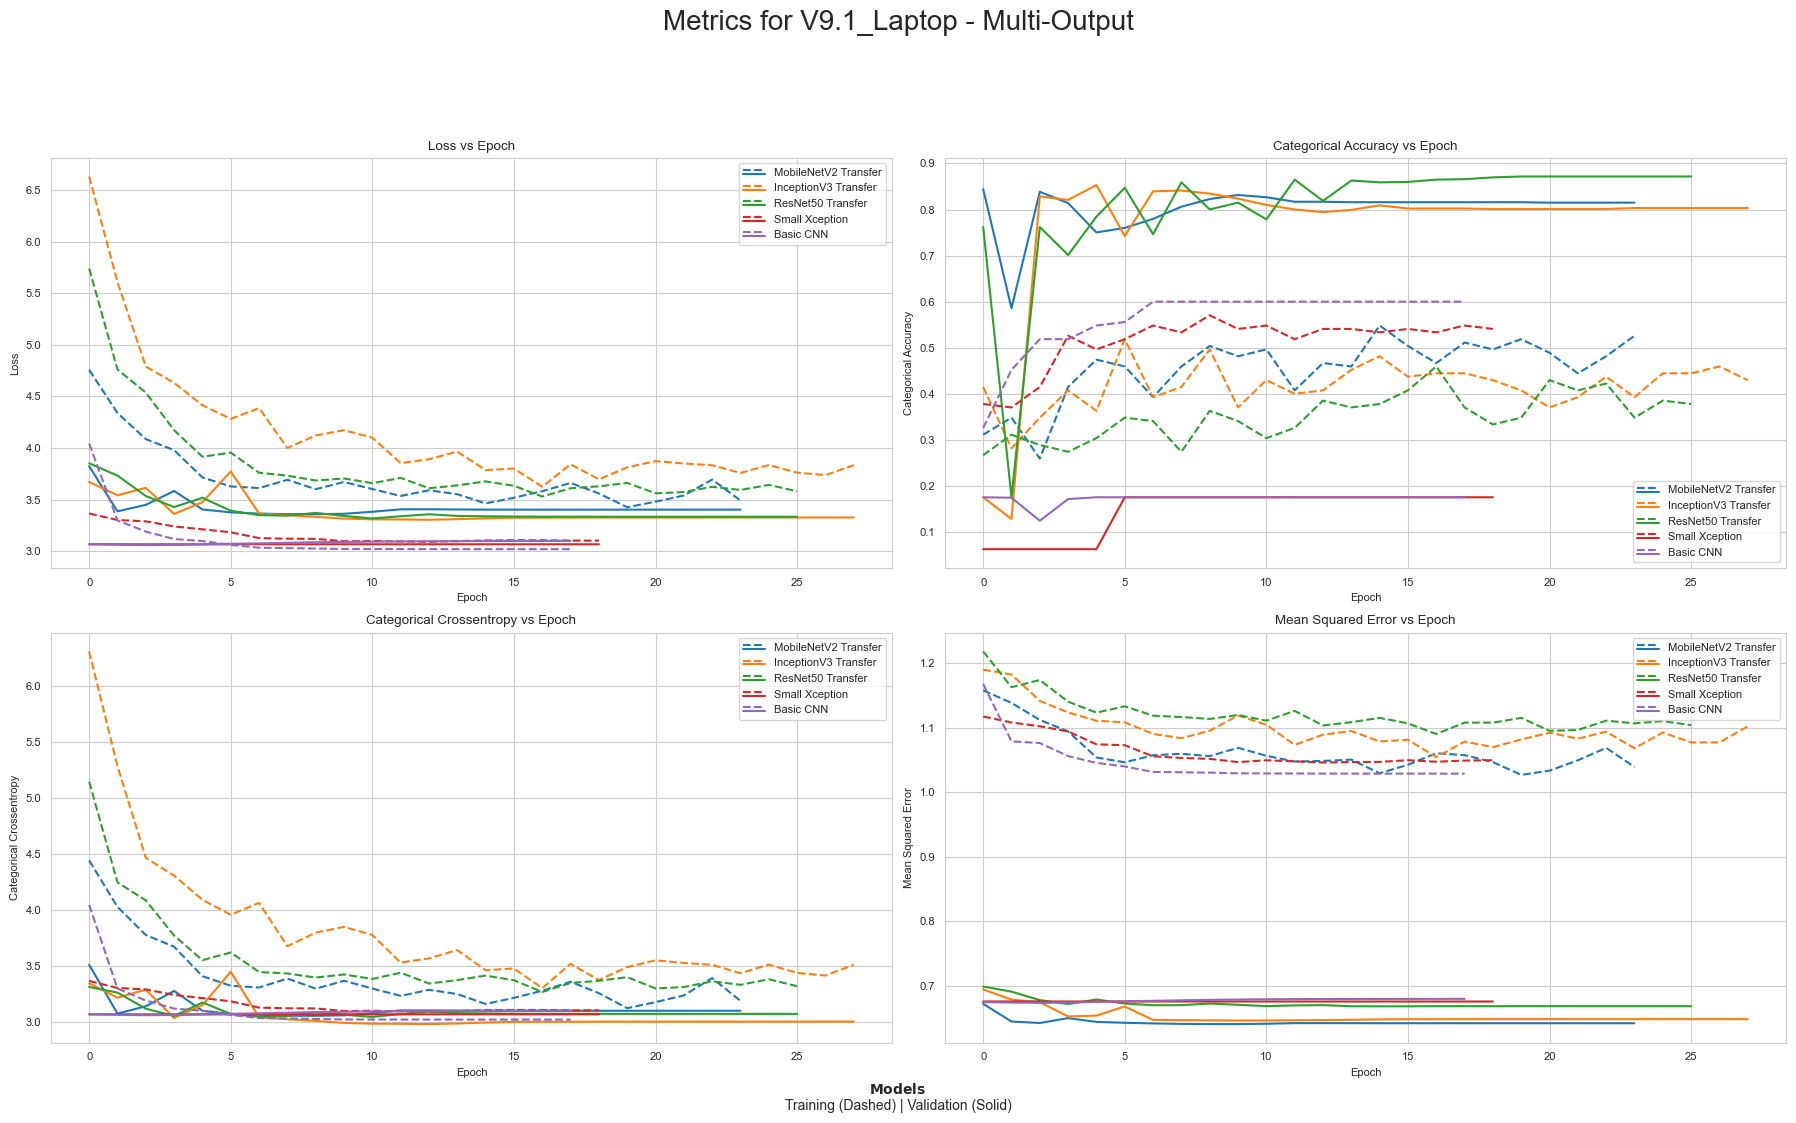

'Plots/V9.1_Laptop - Multi-Output\\Metrics_vs_Epoch.png'

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from matplotlib.legend_handler import HandlerTuple

class HandlerTupleVertical(HandlerTuple):
    def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
        numlines = len(orig_handle)
        handler_map = legend.get_legend_handler_map()
        height_y = (height / numlines)
        leglines = []
        for i, handle in enumerate(orig_handle):
            handler = legend.get_legend_handler(handler_map, handle)
            legline = handler.create_artists(legend, handle, xdescent, (2*i + 1)*height_y, width, 2*height, fontsize, trans)
            leglines.extend(legline)
        return leglines

def get_dataframes_from_excel(xls):
    """Load DataFrames from the Excel file."""
    model_names = xls.sheet_names
    return {model_name: pd.read_excel(xls, model_name) for model_name in model_names}

def plot_metrics(ax, dfs, metric, readable_metric, color_dict):
    """Plot metrics for all models on a single graph."""
    for model_name, cleaned_name in zip(dfs.keys(), color_dict.keys()):
        epochs = dfs[model_name]['epoch']
        ax.plot(epochs, dfs[model_name][f'{metric}'], '--', color=color_dict[cleaned_name], label=f"{cleaned_name}") #Training
        ax.plot(epochs, dfs[model_name][f'val_{metric}'], '-', color=color_dict[cleaned_name], label=f"{cleaned_name}") #Validation
    ax.set_title(f"{readable_metric} vs Epoch")
    ax.set_xlabel('Epoch')
    ax.set_ylabel(readable_metric)
    
model_name_mapping = {
    "mobilenetv2": "MobileNetV2 Transfer",
    "inceptionv3": "InceptionV3 Transfer",
    "resnet50": "ResNet50 Transfer",
    "small_xception": "Small Xception",
    "basic_cnn": "Basic CNN"
}
def plot_metrics_from_excel(excel_path):
    # Load the Excel file and get DataFrames
    xls = pd.ExcelFile(excel_path)
    model_names = xls.sheet_names
    dfs = get_dataframes_from_excel(xls)
    readable_model_names = [model_name_mapping.get(name, name) for name in model_names]
    
    # Metrics mapping and Seaborn style
    metric_mapping = {
        'loss': 'Loss',
        'categorical_accuracy': 'Categorical Accuracy',
        'categorical_crossentropy': 'Categorical Crossentropy',
        'mean_squared_error': 'Mean Squared Error'
    }
    sns.set_style("whitegrid")
    palette = sns.color_palette("tab10", len(model_names))
    color_dict = {readable_name: palette[i] for i, readable_name in enumerate(readable_model_names)}
    
    # Plotting
    fig, axes = plt.subplots(2, 2, figsize=(18, 10))
    axes_flat = axes.ravel()
    for i, (metric, readable_metric) in enumerate(metric_mapping.items()):
        plot_metrics(axes_flat[i], dfs, metric, readable_metric, color_dict)
        # Add legend to each subplot
        handles, labels = axes_flat[i].get_legend_handles_labels()
        new_handles = [(handles[j], handles[j + 1]) for j in range(0, len(handles), 2)]
        axes_flat[i].legend(new_handles, labels[::2], handler_map={tuple: HandlerTupleVertical()})
    
    # Add main title
    experiment_name = os.path.basename(excel_path).replace(".xlsx", "")
    fig.suptitle(f"Metrics for {experiment_name}", fontsize=20, y=1.08)
    
    # Add informational note below the subplots
    note_text = r"$\bf{Models}$" + "\nTraining (Dashed) | Validation (Solid)"
    fig.text(0.5, -0.02, note_text, ha='center', fontsize=10, transform=fig.transFigure)
    
    fig.tight_layout()
    
    # Save and display
    base_dir = os.path.dirname(excel_path)
    output_dir = os.path.join(base_dir, f"Plots/{experiment_name}")
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    save_path = os.path.join(output_dir, "Metrics_vs_Epoch.png")
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()

    return save_path

# Mocking the actual plot as the excel_path is not available
excel_path = 'V9.1_Laptop - Multi-Output.xlsx'
improved_save_path = plot_metrics_from_excel(excel_path)
improved_save_path
